# Some take-ways from this notebook

Greedy strategy can be perfectly and easily approximated by a neural network;
However, greedy strategy itself is sub-optimal compared to shortest path strategies; the 
algorithm can easily be stuck in a cycle, leading to bad results.

One thing that is a bit concerning is that the graph is small; the network
tends to memorize the entire graph; some experiments on much bigger graphs
should be conducted to verify that the network is actually learning something
useful.

It would be very interesting to see to what extent shortest path strategy can be approximated.

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import mxnet as mx
import logging
from sklearn.metrics import accuracy_score
from utils import generate_low_degree_g

In [ ]:
G = generate_low_degree_g(num_nodes=100)
print(G.number_of_nodes())
print(G.number_of_edges())

In [ ]:
nx.draw(G, with_labels=True)
plt.show()

In [ ]:
max_out_degree = max(G.out_degree, key=lambda d: d[1])[1]
max_out_degree

In [ ]:
def generate_dataset(G):
    
    X, y = [], []
    
    for node in G.nodes:

        if G.out_degree(node) == 0:
            print('Node %d has 0 out degree' % node)
            continue

        init_weight_vec = np.ones(max_out_degree)

        for idx, out_edge in enumerate(G.out_edges(node)):
            init_weight_vec[idx] = G.get_edge_data(node, out_edge[1])['weight']

        out_neighbors = map(lambda t: (t[1], G.get_edge_data(node, t[1])['weight']),  G.out_edges(node))
    #     print(node, min(out_neighbors, key=lambda d: d[1]), len(out_neighbors), sorted(out_neighbors))

    #     label = one_hot_encode(np.argmin(init_weight_vec, axis=0))
        label = min(out_neighbors, key=lambda d: d[1])[1]
    #     print(label, init_weight_vec[np.argmin(init_weight_vec)])
        assert label == init_weight_vec[np.argmin(init_weight_vec)]
        X.append(init_weight_vec)
        y.append(label)
    
    return np.array(X), np.array(y)

features, labels = generate_dataset(G)
print(features.shape)
print(labels.shape)

In [ ]:
def augment_dataset(X, y=None, augmentation_index=600):
    
    X_aug, y_aug = [], []
    indices = np.arange(len(X[0]))
    
    for _, x in enumerate(X):
        for _ in range(augmentation_index):
#             np.random.shuffle(indices)
            
            X_aug.append(x[indices])
            y_aug.append(np.argmin(x[indices]))
            
    return np.array(X_aug), np.array(y_aug)

In [ ]:
X_aug, y_aug = augment_dataset(features, labels, augmentation_index=1)
print(X_aug.shape)
print(y_aug.shape)
print(X_aug[1])
print(y_aug[1])

In [ ]:
indices = np.arange(len(X_aug))
np.random.shuffle(indices)
X, y =  X_aug[indices], y_aug[indices]
print(X.shape)
print(y.shape)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

In [ ]:
batch_size = 20

train_iter = mx.io.NDArrayIter(X, y, batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(X, y, batch_size=batch_size)

In [ ]:
def build_model(context=mx.cpu()):
    
    data = mx.sym.var('data')
    label = mx.sym.var('softmax_label')
    
    fc2  = mx.sym.FullyConnected(data=data, num_hidden=32)
    fc2 = mx.sym.Activation(data=fc2, act_type="relu")
    
    fc3  = mx.sym.FullyConnected(data=fc2, num_hidden=max_out_degree)
    mlp  = mx.sym.SoftmaxOutput(data=fc3, label=label)
    
    return mx.mod.Module(symbol=mlp, context=context)

In [ ]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
model = build_model()
model.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
model.init_params()

In [ ]:
model.fit(train_iter,  # train data
              eval_data=val_iter,  # validation data
              optimizer='adam',  # use SGD to train
#               optimizer_params={'learning_rate':0.01, 'momentum': 0.9},
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 10), # output progress for each 100 data batches
              num_epoch=10)  # train for at most 10 dataset passes

In [ ]:
pred_train = np.argmax(model.predict(mx.io.NDArrayIter(X_train, y_train, batch_size=batch_size)).asnumpy(), axis=1)
print('Acc on training set %f' % accuracy_score(y_train, pred_train))

pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test, batch_size=batch_size)).asnumpy(), axis=1)
print('Acc on test set %f' % accuracy_score(y_test, pred_test))

In [ ]:
def infer_next_node(G, cur_node):
#     print("In infer_next_node")
    return min(map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node)), key=lambda d:d[1])

def nn_infer_next_node(G, cur_node, model):
#     print("In nn_infer_next_node")
    input_vec = np.ones(4)
    
    for idx, out_edge in enumerate(G.out_edges(cur_node)):
        input_vec[idx] = G.get_edge_data(cur_node, out_edge[1])['weight']
    
    
    out_neighbors = map(lambda t: (t[1], G.get_edge_data(cur_node, t[1])['weight']),  G.out_edges(cur_node))
    
    pred_idx = np.argmax(model.predict(mx.io.NDArrayIter(np.array([input_vec]), np.array([0]))).asnumpy()[0])
    return out_neighbors[pred_idx]

def greedy_path_finder(G, src, dst, use_nn=False, model=None):
    
    path = [src]
    cur_node = src
    total_weights = .0
    
    while True:
        
        if len(path) >= G.number_of_nodes():
            return path, total_weights, False
        
        next_node, weight = nn_infer_next_node(G, cur_node, model) if use_nn else infer_next_node(G, cur_node)
        total_weights += weight
        path.append(next_node)
        
        if next_node == dst:
            return path, total_weights, True
        
        cur_node = next_node

In [ ]:
def check_greedy_path_finder_acc(G, model):
    
    identical_cnt = 0
    other_cnt = 0
    
    for src in G.nodes:
        for dst in G.nodes:
            
            if src == dst:
                continue
            
            path, _, found = greedy_path_finder(G, src, dst)
            nn_path, _, nn_found = greedy_path_finder(G, src, dst, use_nn=True, model=model)
            
            if path == nn_path:
                identical_cnt += 1
            else:
                other_cnt += 1
            
#             if found == nn_found and found == True:
#                 basic_stat[0] += 1
                
#                 if path == nn_path:
#                     extra_stat['eq'] += 1
#                 elif len(path) < len(nn_path):
#                     extra_stat['nn_path_more'] += 1
#                 elif len(path) > len(nn_path):
#                     extra_stat['path_more'] += 1
#                 else:
#                     pass
# #                     assert False
# #                     print 'greedy_path_finder', path
# #                     print 'nn_greedy_path_finder', nn_path
                
#             elif found == nn_found and found == False:
#                 basic_stat[1] += 1
#             elif found == True and nn_found == False:
#                 basic_stat[2] += 1
#             elif found == False and nn_found == True:
# #                 print src, dst
# #                 print 'greedy_path_finder', path
# #                 print 'nn_greedy_path_finder', nn_path
#                 basic_stat[3] += 1
#             else:
#                 assert False
    
    return identical_cnt, other_cnt

# Validate on new graphs

A model that is trained on one random graph
should and indeed can be used to infer paths
on another random graph. This, to some extent,
proves that the network has gained some knowledge,
which is good news.
In this case, the knowledge is the greedy strategy,
i.e., always go with the edge that has the smallest
weight.

In [ ]:
graph_sizes = [20, 100, 500, 1000]
stats = [[] for _ in range(len(graph_sizes))]
number_of_tests = 100

In [ ]:
for idx, num_nodes in enumerate(graph_sizes):
    
    print('Working on graphs with %d nodes' % num_nodes)
    for i in range(number_of_tests):
        
        if i > 0 and i % 10 == 0:
            print("Processed %d graphs" % i)
            
        G_1 = generate_low_degree_g(num_nodes=num_nodes)
        X_test, y_test = generate_dataset(G_1)
        X_test, y_test = augment_dataset(X_test, y_test, augmentation_index=1)

        pred_test = np.argmax(model.predict(mx.io.NDArrayIter(X_test, y_test)).asnumpy(), axis=1)
        acc = accuracy_score(y_test, pred_test)
        stats[idx].append(acc)

/usr/local/Cellar/python/2.7.14/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/jupyter_client/jsonutil.py:67: DeprecationWarning: Interpreting naive datetime as local 2018-05-28 21:13:57.992823. Please add timezone info to timestamps.
  new_obj[k] = extract_dates(v)


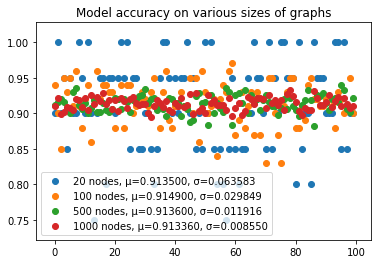

In [214]:
for idx, stat in enumerate(stats):
    stat_mean = np.mean(stat)
    stat_std = np.std(stat)
    label = u'%d nodes, μ=%f, σ=%f' % \
            (graph_sizes[idx], stat_mean, stat_std)
    plt.scatter(list(range(number_of_tests)), stat, label=label)

plt.legend(loc='best')
plt.show()